In [7]:
# IMPORTANT: change this to your locations
model_h5_file_location = f'/scratch/ms7490/code/splicing_library_analysis/2022_03_11_figures/models/custom_adjacency_regularizer_20210731_124_step3.h5'
data_folder = f'/scratch/ms7490/code/splicing_library_analysis/2022_03_11_figures/data'

In [2]:
%load_ext autoreload
%autoreload 2

In [33]:
import os
import sys
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib import patches as pat
from matplotlib import transforms
from matplotlib.collections import PatchCollection
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from joblib import load, dump
import re
import scipy.cluster.hierarchy as sch

from IPython.core import display
from scipy.ndimage import gaussian_filter1d

# custom code
import figutils
import sequence_logo
from quad_model import *
import kl
import force

from collections.abc import Iterable

%matplotlib inline

In [4]:
plt.style.use('clean.mplstyle')

# Load data and models

In [5]:
xTr = load(os.path.join(data_folder, f'xTr_ES7_HeLa_ABC.pkl'))
yTr = load(os.path.join(data_folder, f'yTr_ES7_HeLa_ABC.pkl'))

In [8]:
model_fname = model_h5_file_location
model = tf.keras.models.load_model(model_fname)

2022-09-22 23:12:19.391532: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64:/.singularity.d/libs
2022-09-22 23:12:19.391627: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-22 23:12:19.391644: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cm001.hpc.nyu.edu): /proc/driver/nvidia/version does not exist
2022-09-22 23:12:19.391908: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
num_seq_filters = model.get_layer('qc_incl').kernel.shape[2]
num_struct_filters = model.get_layer('c_incl_struct').kernel.shape[2]

position_bias_size = model.get_layer('position_bias_incl').kernel.shape[0]
struct_filter_width = model.get_layer("c_incl_struct").kernel.shape[0]
input_length = model.input[0].shape[1]

# Group sequence filters

In [10]:
def get_membership_dict(ind):
    out = {}
    
    for i, group_i in enumerate(ind):
        if group_i not in out:
            out[group_i] = []
        out[group_i].append(i)
    return out

def get_fig_num_rows_cols(membership_dict):
    fig_rows = max([len(e) for e in list(membership_dict.values())])
    fig_cols = len(membership_dict.keys())
    return fig_rows, fig_cols 

In [11]:
structure_out_model = Model(inputs=model.inputs, outputs=[
    model.get_layer('activation_2').output,
    model.get_layer('activation_3').output
])

In [12]:
incl_act, skip_act = structure_out_model.predict(xTr, verbose=1, batch_size=1024)
incl_act_seq = incl_act[:, :, :num_seq_filters]
skip_act_seq = skip_act[:, :, :num_seq_filters]

2022-09-22 23:12:26.661711: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


188/188 [==============================] - 48s 254ms/step


In [13]:
incl_activations = dict()
skip_activations = dict()

tmp = (incl_act[:, 1:, :] + incl_act[:, :-1, :])
for k in tqdm(range(num_seq_filters)):
    a = tmp[:, :, k][:, 10:-10].max(axis=1).mean()
    incl_activations[k] = a

tmp = (skip_act[:, 1:, :] + skip_act[:, :-1, :])
for k in tqdm(range(num_seq_filters)):
    a = tmp[:, :, k][:, 10:-10].max(axis=1).mean()
    skip_activations[k] = a

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [14]:
incl_inds = sch.fcluster(sch.linkage(incl_act_seq.sum(axis=1).T,
                               metric='correlation',
                               method='complete'),
                   t=0.9,
                   criterion='distance')

skip_inds = sch.fcluster(sch.linkage(skip_act_seq.sum(axis=1).T,
                               metric='correlation',
                               method='complete'),
                   t=0.9,
                   criterion='distance')

Visualize grouped filters

In [15]:
qc_incl = model.get_layer('qc_incl')
qc_skip = model.get_layer('qc_skip')

logo_dfs_incl_simple = figutils.compute_activations_simple_conv(qc_incl)
logo_dfs_skip_simple = figutils.compute_activations_simple_conv(qc_skip)

In [16]:
incl_membership_dict = get_membership_dict(incl_inds)
skip_membership_dict = get_membership_dict(skip_inds)

  0%|          | 0/7 [00:00<?, ?it/s]

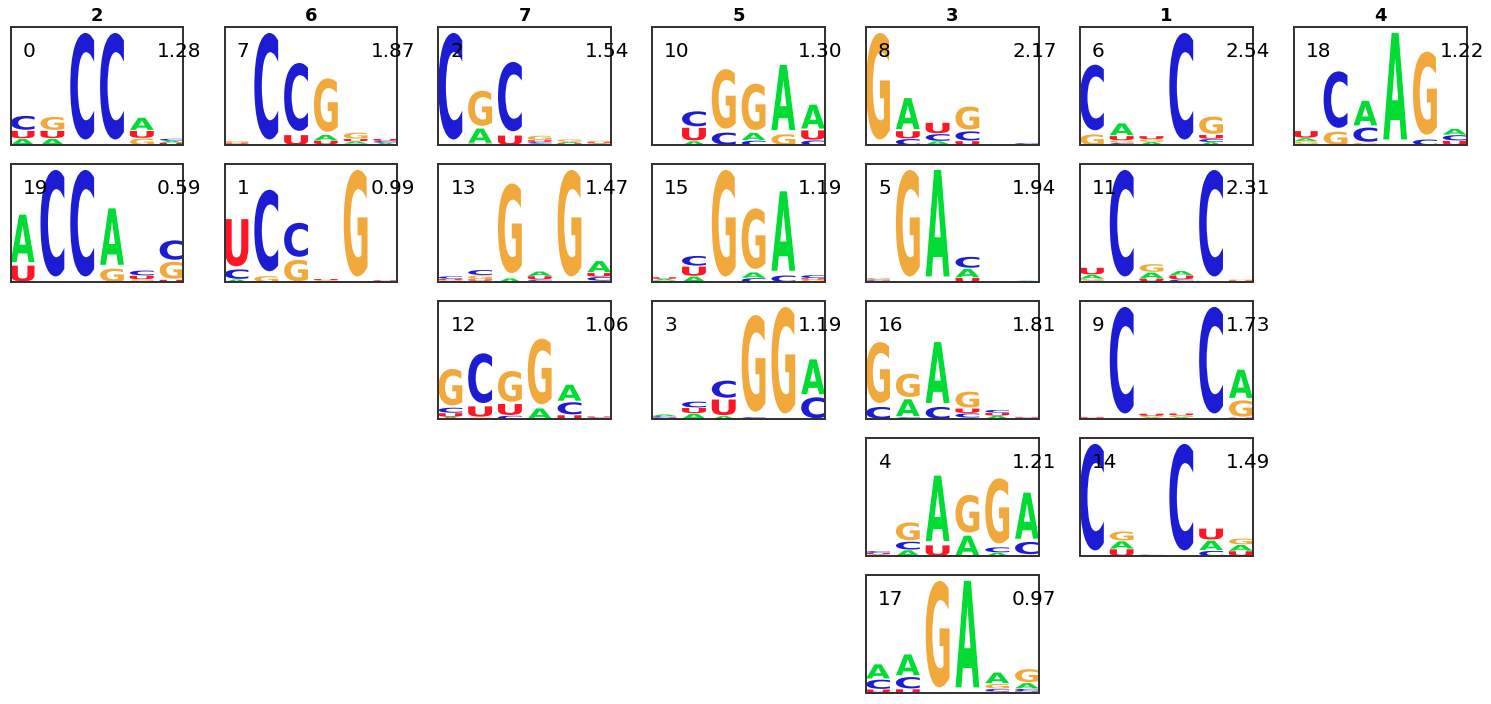

In [18]:
# incl filters
fig_rows, fig_cols = get_fig_num_rows_cols(incl_membership_dict)
fig, axarr = plt.subplots(fig_rows, fig_cols, figsize=[3 * fig_cols, 2 * fig_rows], sharex=True, sharey=True)

for ax in axarr.flatten():
    ax.axis('off')

for idx, mem_list_key in enumerate(tqdm(incl_membership_dict.keys())):
    mem_list = incl_membership_dict[mem_list_key]
    for jdx, filter_num in enumerate(sorted(mem_list, key=lambda x:-incl_activations[x])):
        axarr[jdx, idx].axis('on')
        df = logo_dfs_incl_simple[filter_num]
        act_thresh = 0 if df.query('activation > 0').shape[0] == 0 else 0
        sequence_logo.plot_logo(df, act_thresh, axarr[jdx, idx])
        axarr[jdx, idx].spines['right'].set_visible(True)
        axarr[jdx, idx].spines['top'].set_visible(True)
        axarr[jdx, idx].set_xticks([])
        axarr[jdx, idx].set_yticks([])
        axarr[jdx, idx].text(0, 1.5, f'{filter_num}', fontsize=20)
        axarr[jdx, idx].text(4.5, 1.5, f'{incl_activations[filter_num]:.2f}', fontsize=20)
    axarr[0, idx].set_title(f'{mem_list_key}')
        

plt.tight_layout()
fig.savefig(
    './figs/incl_seq_filters_clustered.svg',
    pad_inches=0.1,
    bbox_inches='tight')
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

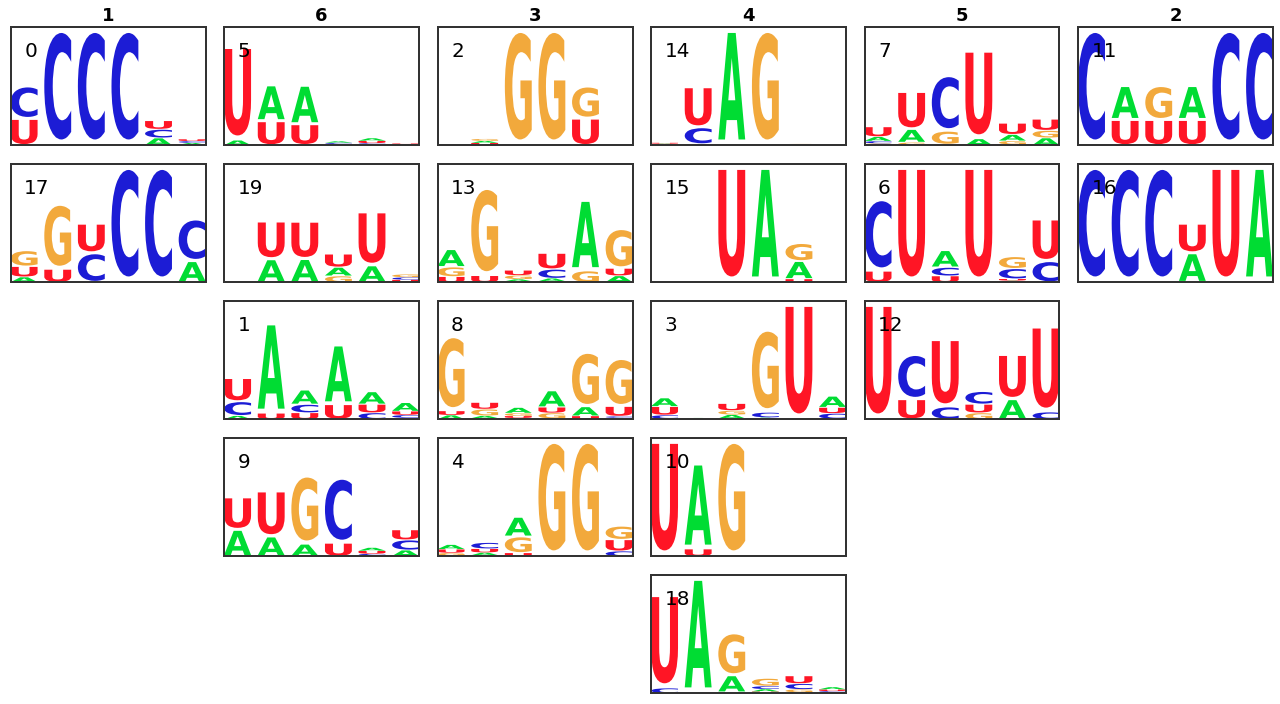

In [19]:
# skip filters
fig_rows, fig_cols = get_fig_num_rows_cols(skip_membership_dict)
fig, axarr = plt.subplots(fig_rows, fig_cols, figsize=[3 * fig_cols, 2 * fig_rows], sharex=True, sharey=True)

for ax in axarr.flatten():
    ax.axis('off')

for idx, mem_list_key in enumerate(tqdm(skip_membership_dict.keys())):
    mem_list = skip_membership_dict[mem_list_key]
    for jdx, filter_num in enumerate(sorted(mem_list, key=lambda x:-skip_activations[x])):
        axarr[jdx, idx].axis('on')
        df = logo_dfs_skip_simple[filter_num]
        act_thresh = 0 if df.query('activation > 0').shape[0] == 0 else 0
        sequence_logo.plot_logo(df, act_thresh, axarr[jdx, idx])
        axarr[jdx, idx].spines['right'].set_visible(True)
        axarr[jdx, idx].spines['top'].set_visible(True)
        axarr[jdx, idx].set_xticks([])
        axarr[jdx, idx].set_yticks([])
        axarr[jdx, idx].text(0, 1.5, f'{filter_num}', fontsize=20)
    axarr[0, idx].set_title(f'{mem_list_key}')
        

plt.tight_layout()
fig.savefig(
    './figs/skip_seq_filters_clustered.svg',
    pad_inches=0.1,
    bbox_inches='tight')
plt.show()

# Dump representative sequence filters

Strategy: the representative is the one with highest mean activation

In [20]:
def get_representative_dict(membership_dict, activations):
    scores = activations.sum(axis=1).mean(axis=0)
    out = dict()
    
    for cluster_id in membership_dict:
        filter_ids = membership_dict[cluster_id]
        
        top_filter = np.argmax(scores[filter_ids])
        out[cluster_id] = filter_ids[top_filter]
    return out

In [21]:
incl_representative_dict = get_representative_dict(incl_membership_dict, incl_act_seq)
skip_representative_dict = get_representative_dict(skip_membership_dict, skip_act_seq)

Manually fix representatives

In [22]:
skip_representative_dict[4] = 10
incl_representative_dict[3] = 5

In [23]:
seq_filters_grouping = dict(incl_membership_dict=incl_membership_dict,
     skip_membership_dict=skip_membership_dict,
     incl_representative_dict=incl_representative_dict,
     skip_representative_dict=skip_representative_dict)
dump(seq_filters_grouping, './data/seq_filters_grouping.pkl')

['./data/seq_filters_grouping.pkl']

# Visualize structure filters

In [24]:
def extract_str_patches(lst, n):
    out = []
    for elem in lst:
        tmp = []
        n_elem = len(elem)
        assert n_elem >= n, f'{elem} is of length < n ({n})'
        for i in range(n_elem - n + 1):
            tmp.append(elem[i:i+n])
        out.append(tmp)
    return out

In [25]:
# structure filter properties to convert same padding to valid
left_struct_pad = (struct_filter_width - 1) // 2
right_struct_pad = struct_filter_width - 1 - left_struct_pad
struct_left_cutoff = left_struct_pad - 2
struct_right_cutoff = right_struct_pad - 3


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


Iterating over k-mer list:   0%|          | 0/2864 [00:00<?, ?it/s]

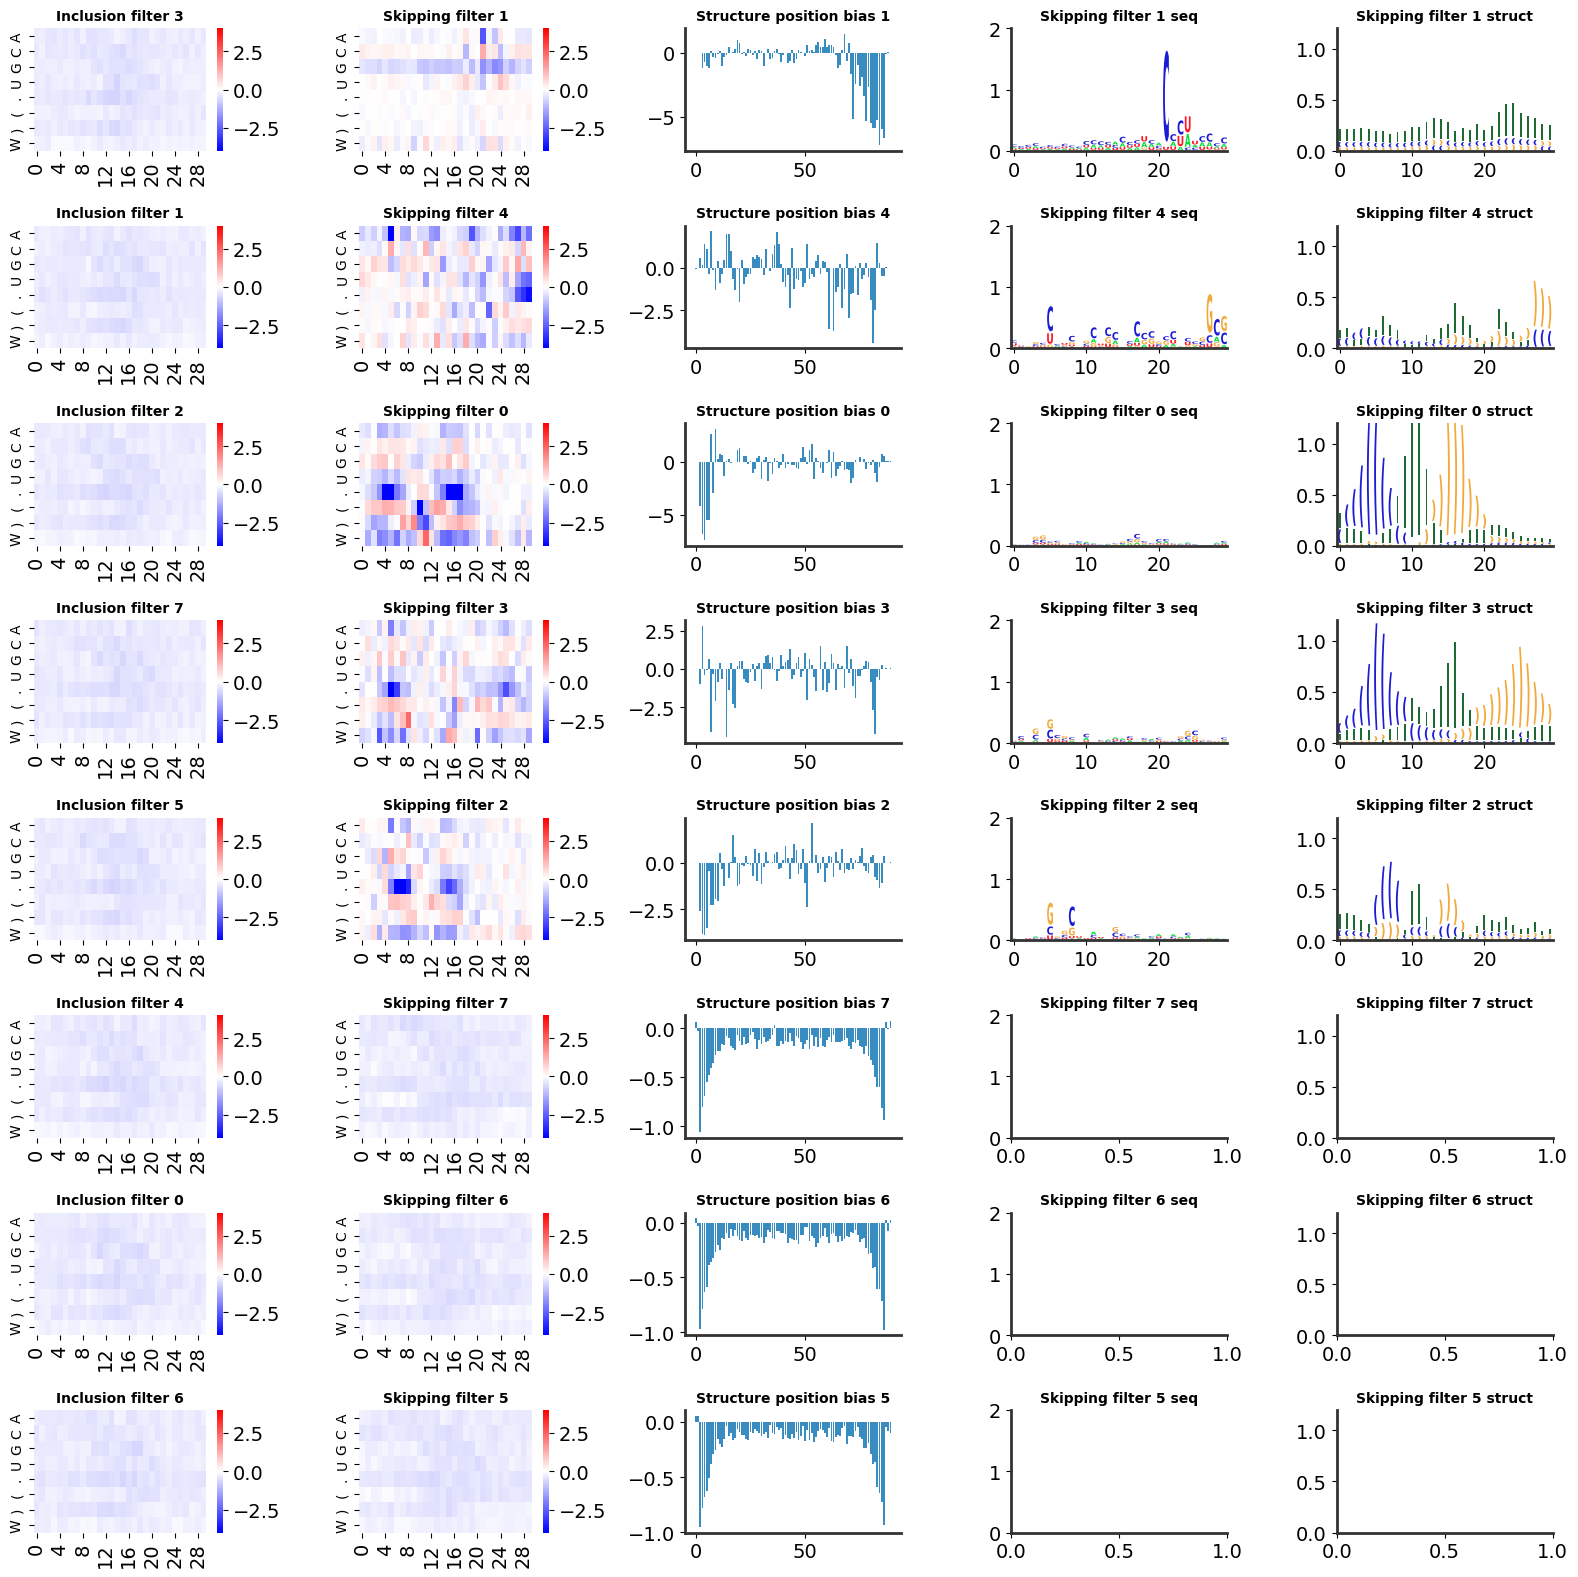

In [26]:
incl_conv_W, incl_conv_b = model.get_layer('c_incl_struct').weights
skip_conv_W, skip_conv_b = model.get_layer('c_skip_struct').weights

N = 1000
xTr_subset = [xTr[0][:N], xTr[1][:N], xTr[2][:N]]
incl_acts, skip_acts = structure_out_model.predict(xTr_subset, verbose=0, batch_size=20)

incl_order = np.argsort(incl_acts[..., num_seq_filters:].sum(axis=1).mean(axis=0))[::-1]
skip_order = np.argsort(skip_acts[..., num_seq_filters:].sum(axis=1).mean(axis=0))[::-1]

xTr_subset_nt = figutils.oh_2_str(xTr_subset[0], kind='seq')
A = extract_str_patches(xTr_subset_nt, struct_filter_width)
B = [(c, *d) for a, b in zip(
    A, skip_acts[:, struct_left_cutoff:-struct_right_cutoff, num_seq_filters:])
     for c, d in zip(a, b)]
acts_df = pd.DataFrame(B,
                       columns=['input'] +
                       [f'f{i}' for i in range(num_struct_filters)])

xTr_struct_subset_nt = figutils.oh_2_str(xTr_subset[1], kind='struct')
As = extract_str_patches(xTr_struct_subset_nt, struct_filter_width)
Bs = [(c, *d) for a, b in zip(
    As, skip_acts[:, struct_left_cutoff:-struct_right_cutoff,
                  num_seq_filters:]) for c, d in zip(a, b)]
acts_df_struct = pd.DataFrame(Bs,
                              columns=['input'] +
                              [f'f{i}' for i in range(num_struct_filters)])

fig, axarr = plt.subplots(num_struct_filters,
                          5,
                          figsize=(16, 16),
                          dpi=100,
                          sharex=False,
                          sharey=False)

M = model.get_layer('position_bias_skip_struct').kernel.numpy()
for i in range(num_struct_filters):
    sns.heatmap(incl_conv_W[..., incl_order[i]].numpy().T,
                cmap='bwr',
                ax=axarr[i, 0],
                vmin=-4,
                vmax=4)
    axarr[i, 0].set_yticks(np.arange(8) + 0.5)
    axarr[i, 0].set_yticklabels(("A", "C", "G", "U", ".", "(", ")", "W"),
                                fontsize=10)
    axarr[i, 0].set_title(f'Inclusion filter {incl_order[i]}', fontsize=10)

    sns.heatmap(skip_conv_W[..., skip_order[i]].numpy().T,
                cmap='bwr',
                ax=axarr[i, 1],
                vmin=-4,
                vmax=4)
    axarr[i, 1].set_yticks(np.arange(8) + 0.5)
    axarr[i, 1].set_yticklabels(("A", "C", "G", "U", ".", "(", ")", "W"),
                                fontsize=10)
    axarr[i, 1].set_title(f'Skipping filter {skip_order[i]}', fontsize=10)
    
    axarr[i, 2].bar(range(input_length), M[:, skip_order[i]])
    axarr[i, 2].set_title(f'Structure position bias {skip_order[i]}', fontsize=10)
    
    df = acts_df[['input', f'f{skip_order[i]}']]
    df.columns = ['input', 'activation']
    df = df.reset_index()
    sequence_logo.plot_logo(df, 2, axarr[i, 3])
    axarr[i, 3].set_ylim(0, 2)
    axarr[i, 3].set_title(f'Skipping filter {skip_order[i]} seq', fontsize=10)
    
    dfS = acts_df_struct[['input', f'f{skip_order[i]}']]
    dfS.columns = ['input', 'activation']
    dfS = dfS.reset_index(drop=True)
    sequence_logo.plot_logo(dfS, 1, axarr[i, 4], nts=['.', '(', ')'], color_map={".": "#1f6933", "(": "#1c1cd5", ")": "#f2a93c"})
    axarr[i, 4].set_ylim(0, 1.2)
    axarr[i, 4].set_title(f'Skipping filter {skip_order[i]} struct', fontsize=10)
    

plt.tight_layout()

# Group structure filters and dump representatives

In [27]:
incl_membership_struct_dict = {1: np.array([0, 1, 2, 3, 4, 5, 6, 7])}
skip_membership_struct_dict = {1: np.array([1]), 2: np.array(
    [0, 2, 3]), 3: np.array([5, 6, 7]), 4: np.array([4])}
incl_representative_struct_dict = {1: 0}
skip_representative_struct_dict = {1: 1, 2: 0, 3: 5}

struct_filters_grouping = dict(incl_membership_dict=incl_membership_struct_dict,
     skip_membership_dict=skip_membership_struct_dict,
     incl_representative_dict=incl_representative_struct_dict,
     skip_representative_dict=skip_representative_struct_dict)

dump(struct_filters_grouping, './data/struct_filters_grouping.pkl')

['./data/struct_filters_grouping.pkl']

# Make table of representative filters

- For each exon, each filter group: compute total activation per group
- Compute 90th percentile of each groups activations

In [28]:
incl_color = '#669aff'
skip_color = '#ff6666'
light_incl_color = '#C5D6FB'
light_skip_color = '#F6C3C2'

In [29]:
incl_membership_scores = {
    key: np.quantile(incl_act_seq[:, :, incl_membership_dict[key]].sum(axis=(1, 2)), 0.9)
    for key in incl_membership_dict.keys()
}
skip_membership_scores = {
    key: np.quantile(skip_act_seq[:, :, skip_membership_dict[key]].sum(axis=(1, 2)), 0.9)
    for key in skip_membership_dict.keys()
}

In [30]:
incl_plot_order = sorted(incl_membership_scores, key=lambda x: -incl_membership_scores[x])
skip_plot_order = sorted(skip_membership_scores, key=lambda x: -skip_membership_scores[x])

In [31]:
def all_above_x(arr, x):
    return arr[arr > x]

def all_above_x(arr, x):
    return arr[(arr > np.quantile(arr, x[0])) * (arr < np.quantile(arr, x[1]))]

In [32]:
def index_above_quantile(arr, q):
    return arr > np.quantile(arr, q)

In [34]:
def draw_number(ax, number, color, set_xlimits=False):
    ax.text(-1.5, 1, f"{number}", color='k',
            fontweight='normal', ha='center', va='center', fontsize=15,
            bbox={"boxstyle": "circle", "facecolor": color, "linewidth": 1, 'edgecolor': 'k'})
    if set_xlimits:
        ax.set_xlim(-0.5, 5.5)
        ax.set_ylim(0,  2)

In [35]:
def draw_numbered_text(ax, number, text, color, set_xlimits=False):
    ax.text(0.5, 0.5, s=text, fontsize=15,
            transform=ax.transAxes, ha='center', va='center')
    draw_number(ax, number, color, set_xlimits)

In [36]:
def plot_logo(ax, df, num_idx, color):
    act_thresh = 0 if df.query('activation > 0').shape[0] == 0 else 0
    sequence_logo.plot_logo(df, act_thresh, ax)
    draw_number(ax, num_idx+1, color)
    ax.set_xlim(-0.5, 5.5)
    ax.set_ylim(0,  2)

In [37]:
def get_position_slope(activations_tensor, quantile_threshold):
    tt = index_above_quantile(activations_tensor.sum(axis=(1,2)), quantile_threshold)
    slope = activations_tensor.sum(axis=2)[tt].mean(axis=0)[10:-10]
    return slope

In [38]:
def plot_slope(ax, slope, color):
    ax.plot(
        range(len(slope)), slope, color='#868686', linewidth=2, clip_on=False)
    ax.fill_between(
        range(len(slope)), 0, slope, color=color)
    ax.set_xlim(0, len(slope))
    ax.set_ylim(0, 1.1)
    
    # add thin line around plot
    ax.plot([0, 0, len(slope), len(slope)],
                                          [slope[0], 0, 0, slope[-1]],
                                          color='#868686', linewidth=2,
                                          clip_on=False
                                         )

In [39]:
def get_and_plot_slope(ax, activations_tensor, quantile_threshold, color, smooth=False, draw_yaxis=False):
    slope = get_position_slope(activations_tensor, quantile_threshold)
    if smooth:
        slope = gaussian_filter1d(slope, 1)
    plot_slope(ax, slope, color)
    
    if draw_yaxis:
        ax.axis('on')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(True)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

In [40]:
top_k = 4
num_extra_filters = 2

In [41]:
incl_motif_j = 0
incl_position_bias_j = 1
skip_motif_j = 2
skip_position_bias_j = 3

In [42]:
activation_quantile_threshold = 0.95

findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Arial


incl 1 0
skip 6 6
incl 3 1
skip 4 7
incl 7 2
skip 3 8
incl 5 3
skip 1 9
incl 6 4
incl 2 5


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


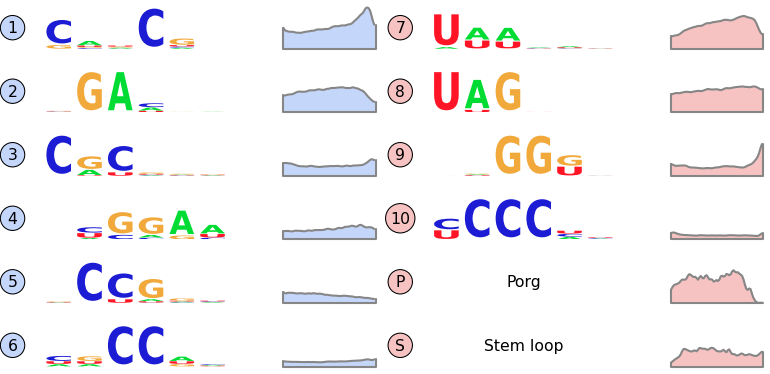

In [43]:
fig, axarr = plt.subplots(top_k + num_extra_filters, 4, figsize=(
    12, 1 * (top_k + num_extra_filters)), sharex=False, sharey=False,
                          dpi=75, gridspec_kw={'width_ratios': [2, 1, 2, 1]})

for axrow in axarr:
    for ax in axrow:
        ax.axis('off')
        ax.set_yticks([])

special_skip_numbers = {top_k:'P', (top_k+1):'S'}
special_skip_text = {top_k:'Porg', (top_k+1):'Stem loop'}
special_skip_filters = {top_k:[1], (top_k+1):[0,2,3]}

for idx in range(top_k + num_extra_filters):
    # inclusion
    incl_key = incl_plot_order[idx]
    incl_filter_num = incl_representative_dict[incl_key]
    print('incl', incl_key, idx)
    incl_df = logo_dfs_incl_simple[incl_filter_num]
    
    plot_logo(axarr[idx, incl_motif_j], incl_df, idx, light_incl_color)
    get_and_plot_slope(axarr[idx, incl_position_bias_j],
                       incl_act_seq[:, :, incl_membership_dict[incl_key]],
                       activation_quantile_threshold,
                       light_incl_color, smooth=True,
                       draw_yaxis=True
                      )
    
    # skipping
    if idx < top_k:
        skip_key = skip_plot_order[idx]
        skip_filter_num = skip_representative_dict[skip_key]
        print('skip', skip_key, idx + top_k + num_extra_filters)
        skip_df = logo_dfs_skip_simple[skip_filter_num]
        # offset the skipping motifs' index by top_k + num_extra_filters
        plot_logo(axarr[idx, skip_motif_j], skip_df, idx + top_k + num_extra_filters, light_skip_color)
        
        skip_acts_tensor = skip_act_seq[:, :, skip_membership_dict[skip_key]]
    else:
        draw_numbered_text(axarr[idx, skip_motif_j], special_skip_numbers[idx], special_skip_text[idx],
                           light_skip_color, set_xlimits=True)
        skip_acts_tensor = skip_act[:, :, num_seq_filters:][:, :, special_skip_filters[idx]]
        
    get_and_plot_slope(axarr[idx, skip_position_bias_j],
                       skip_acts_tensor,
                       activation_quantile_threshold,
                       light_skip_color,
                       smooth=True,
                       draw_yaxis=True
                      )
        

    

        
fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.5)

fig.savefig('./figs/representative_filters.svg',
            transparent=True, pad_inches='tight')
fig.savefig('./figs/representative_filters.pdf',
            transparent=True, pad_inches='tight')

# Force plots

## Prerequisites

In [44]:
incl_filter_lookup = {}
for key, value in seq_filters_grouping['incl_membership_dict'].items():
    incl_filter_lookup[f'incl_seq_' + '_'.join(map(str, sorted(value)))] = incl_plot_order.index(key) + 1
for key, value in struct_filters_grouping['incl_membership_dict'].items():
    incl_filter_lookup[f'incl_struct_' + '_'.join(map(str, sorted(value)))] = incl_plot_order.index(key) + 1
    
skip_filter_lookup = {}
for key, value in seq_filters_grouping['skip_membership_dict'].items():
    skip_filter_lookup[f'skip_seq_' + '_'.join(map(str, sorted(value)))] = skip_plot_order.index(key) + 1
for key, value in struct_filters_grouping['skip_membership_dict'].items():
    skip_filter_lookup[f'skip_struct_' + '_'.join(map(str, sorted(value)))] = skip_plot_order.index(key) + 1

In [45]:
# Manually add Borg and structure and inclusion bias
skip_filter_lookup['skip_struct_0_2_3'] = 'S'
skip_filter_lookup['skip_struct_1'] = 'P'
skip_filter_lookup['skip_struct_5_6_7'] = '.'
incl_filter_lookup['incl_bias'] = 'B'
skip_filter_lookup['skip_struct_4'] = ' '

In [46]:
# Manually relabel skipping filters
skip_filter_lookup
for idx in range(len(skip_plot_order)):
    skip_key = skip_plot_order[idx]
    skip_filter_num = skip_representative_dict[skip_key]
    skip_filter_group = [b for a,b in list(seq_filters_grouping['skip_membership_dict'].items()) if skip_filter_num in b][0]
    key = f'skip_seq_' + '_'.join(map(str, sorted(skip_filter_group)))
    
    skip_filter_lookup[key] = idx + 1 + top_k + num_extra_filters
    print(key, skip_filter_lookup[key])

skip_seq_1_5_9_19 7
skip_seq_3_10_14_15_18 8
skip_seq_2_4_8_13 9
skip_seq_0_17 10
skip_seq_6_7_12 11
skip_seq_11_16 12


## Plot tuner function

In [47]:
link_input = Input(shape=(1,))
w = model.get_layer('energy_seq_struct').w.numpy()
b = model.get_layer('energy_seq_struct').b.numpy()
link_output = model.get_layer('output_activation')(model.get_layer('gen_func')(w*link_input + b))
link_function = Model(inputs=link_input, outputs=link_output)

link_midpoint = force.get_link_midpoint(link_function)

xs = np.linspace(-40, 40, 100)
ys = link_function(link_midpoint+xs[:, None]).numpy().flatten()

ys_sigmoid = 1/(1 + np.exp(-xs))

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


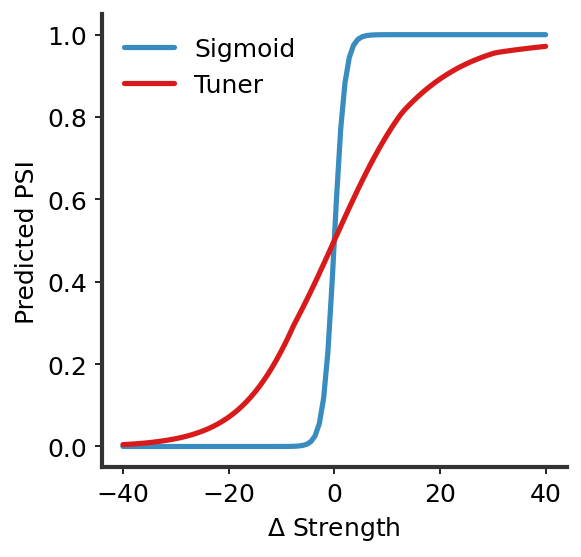

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=150)
ax.plot(xs, ys_sigmoid, label='Sigmoid')
ax.plot(xs, ys, label='Tuner')
ax.legend(loc='upper left', frameon=False, fontsize=12)

ax.set_ylabel('Predicted PSI', fontsize=12)
ax.set_xlabel('$\Delta$ Strength', fontsize=12)
ax.tick_params(axis='both', labelsize=12)

fig.savefig('./figs/tuner.svg', pad_inches=0.1,
    bbox_inches='tight')
fig.savefig('./figs/tuner.pdf', pad_inches=0.1,
    bbox_inches='tight')


## Multiple force plots

In [49]:
def draw_force_plot(data_incl_act, data_skip_act,
                    annotations,
                    seq_filters_grouping, struct_filters_grouping,
                    num_seq_filters, link_midpoint, highlight_forces,
                    incl_color, skip_color, light_incl_color, light_skip_color,
                    figsize=(40/2, 10/2), force_y_range=(0, 90), delta_force_y_range=(-15, 25),
                    ys=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6,
                        0.7, 0.8, 0.9, 0.95, 0.98, 0.986],
                    draw_numbers=False,
                    numbers_min_bar_height=4,
                    label_rotation=0, label_alignment='center', delta_bar_width=2, width_ratios=[2, 2],
                    height_ratios=[1, 1],
                    vertical=False, sharex=False, axislinewidth=1
                    ):
    assert data_incl_act.shape == data_skip_act.shape

    N = data_incl_act.shape[0]
    if vertical:
        fig, axarr = plt.subplots(2, 1, figsize=figsize, dpi=150, gridspec_kw={
            'height_ratios': height_ratios}, sharex=sharex)
    else:
        fig, axarr = plt.subplots(1, 2, figsize=figsize, dpi=150, gridspec_kw={
                                  'width_ratios': width_ratios})

    for idx in range(N):
        incl_act = data_incl_act[idx]
        skip_act = data_skip_act[idx]

        incl_forces, skip_forces = force.create_force_data(incl_act, skip_act,
                                                           seq_filters_grouping, struct_filters_grouping,
                                                           num_seq_filters, sum_positions=True, link_midpoint=link_midpoint)

        incl_forces = force.merge_small_forces(
            incl_forces, threshold=0).sort_values(ascending=False)
        skip_forces = force.merge_small_forces(
            skip_forces, threshold=0).sort_values(ascending=False)

        total_i = 0
        total_s = 0
        for (f_i_name, f_i), (f_s_name, f_s) in zip(incl_forces.items(), skip_forces.items()):
            if f_i_name in highlight_forces:
                f_i_color = incl_color
            else:
                f_i_color = light_incl_color
            if f_s_name in highlight_forces:
                f_s_color = skip_color
            else:
                f_s_color = light_skip_color

            axarr[0].bar([3*idx], [f_i], bottom=[total_i], color=f_i_color,
                         linewidth=1, edgecolor='#6b6b6b', width=1, zorder=2)
            total_i += f_i
            axarr[0].bar([3*idx+1], [f_s], bottom=[total_s],
                         color=f_s_color, linewidth=1, edgecolor='#6b6b6b', width=1, zorder=2)
            total_s += f_s

            # draw numbers
            if draw_numbers:
                labels_i = [incl_filter_lookup[e]
                            for e in f_i_name.split("___")]
                labels_s = [skip_filter_lookup[e]
                            for e in f_s_name.split("___")]

                if f_i > numbers_min_bar_height:
                    axarr[0].text(3*idx, total_i - f_i/2,
                                  labels_i[0], ha='center', va='center')
                if f_s > numbers_min_bar_height:
                    axarr[0].text(3*idx + 1, total_s - f_s/2,
                                  labels_s[0], ha='center', va='center')

        delta_force = incl_forces.sum() - skip_forces.sum()
        axarr[1].bar([3*idx + 0.5], [delta_force], color='#dad7cd' if delta_force <
                     0 else '#dad7cd', linewidth=1, edgecolor='#6b6b6b', width=delta_bar_width, zorder=2)

    axarr[0].set_ylim(*force_y_range)
    axarr[0].set_yticks(20 * np.unique(np.arange(force_y_range[1] +
                        1 if force_y_range[1] % 20 == 0 else force_y_range[1]) // 20))

    axarr[1].set_ylim(*delta_force_y_range)

    axarr[0].grid(axis='y', which='both', zorder=0)
    axarr[1].grid(axis='y', which='both', zorder=0)
    xmin, xmax = axarr[1].get_xlim()
    axarr[1].hlines(0, xmin, xmax, color='k', zorder=3, linewidth=1)
    axarr[1].set_xlim(xmin, xmax)

    axarr[0].set_ylabel('Strength (a.u.)', fontsize=14)
    axarr[1].set_ylabel('$\Delta$ Strength (a.u.)', fontsize=14)
    axarr[0].spines['right'].set_visible(True)

    axarr[0].set_xticks([3*i + 0.5 for i, _ in enumerate(annotations)])
    axarr[0].set_xticklabels([annotations[i] for i, _ in enumerate(
        annotations)], rotation=label_rotation, ha=label_alignment)

    axarr[1].set_xticks([3*i + 0.5 for i, _ in enumerate(annotations)])
    axarr[1].set_xticklabels([annotations[i] for i, _ in enumerate(
        annotations)], rotation=label_rotation, ha=label_alignment)

    xs = [force.get_link_midpoint(
        link_function, midpoint=m)-link_midpoint for m in ys]
    ys = [np.round(e, 2) for e in ys]

    ax2 = axarr[1].twinx()
    axarr[1].spines['right'].set_visible(True)

    ax2.set_yticks(xs)
    ax2.set_yticklabels(ys)
    ax2.set_ylim(*delta_force_y_range)
    ax2.set_ylabel('Predicted PSI', fontsize=14)
    
    for ax in axarr:
        ax.tick_params(axis='both', labelsize=12, length=0)

    fig.tight_layout()

    return axarr, fig

### Structure force plot - 2c1 (main paper)

In [50]:
def get_mutation_names(list_o_exons, rna=False):
    assert len(list_o_exons) > 1
    if rna:
        list_o_exons = [e.replace('T', 'U') for e in list_o_exons]
    
    out = ['']
    
    base = list_o_exons[0]
    
    for exon in list_o_exons[1:]:
        tmp = []
        assert len(base) == len(exon)
        for i, (a, b) in enumerate(zip(base, exon)):
            if a != b:
                tmp.append(f'{i+1}{a}>{b}')
        out.append('\n'.join(tmp))
    return out

In [51]:
def add_subscript(a, b=''):
    return f'{a}\n{b}'

In [52]:
structure_exons = ['GAGTCCCGCTTACCATTGCATTTAAGAAAGCGGCCATACGCCGCTAAGACCCTACTCTTCAGAATACCAG',
'GAGTCCCGCTTACCATTGCATTTAAGAAAGAGGCCATACGCCGCTAAGACCCTACTCTTCAGAATACCAG',
'GAGTCCCGCTTACCATTGCATTTAAGAAAGCGGCCATACGCCTCTAAGACCCTACTCTTCAGAATACCAG',
'GAGTCCCGCTTACCATTGCATTTAAGAAAGAGGCCATACGCCTCTAAGACCCTACTCTTCAGAATACCAG']
letters = ['A', 'B', 'C', 'D']
prefix = 'S1'
annotations = [add_subscript(prefix, subscript) for subscript in get_mutation_names(structure_exons, rna=True)]

structure_sequences = [
    figutils.add_flanking(e, 10) for e in structure_exons
]
structure_data = figutils.create_input_data(structure_sequences)
structure_incl_act, structure_skip_act = structure_out_model.predict(
    structure_data)

highlight_forces = ['skip_struct_0_2_3']

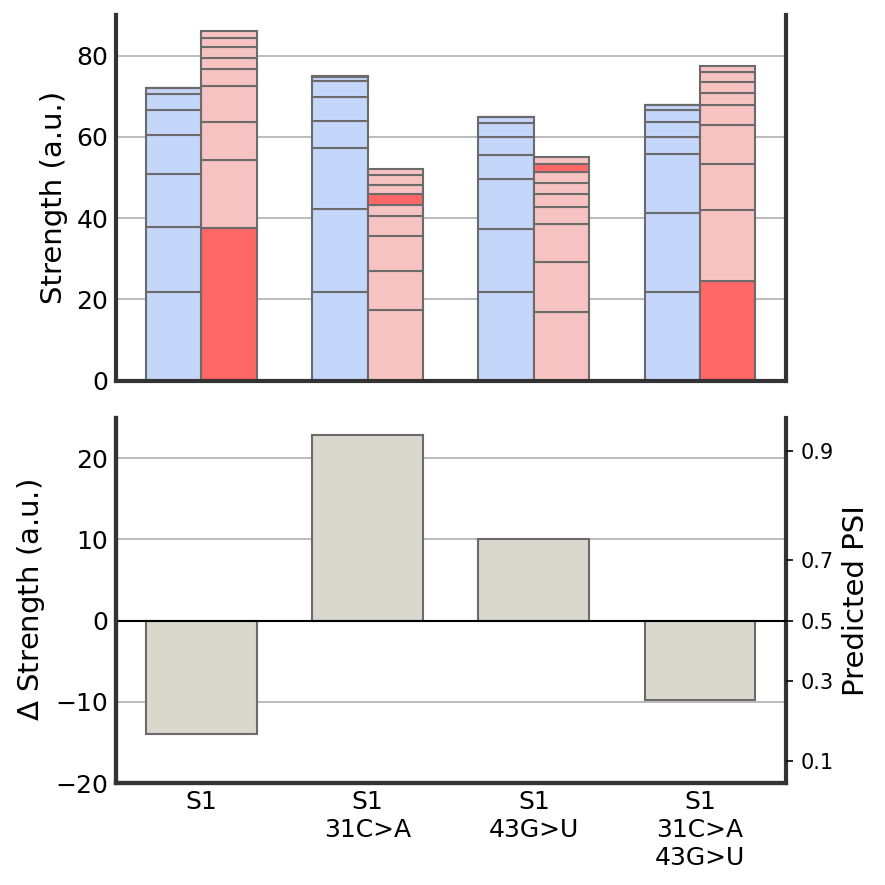

In [53]:
axarr, fig = draw_force_plot(structure_incl_act, structure_skip_act,
                             annotations,
                             seq_filters_grouping, struct_filters_grouping,
                             num_seq_filters, link_midpoint, highlight_forces,
                             incl_color, skip_color, light_incl_color, light_skip_color, 
                             ys=[0.1, 0.3, 0.5, 0.7, 0.9], delta_force_y_range=(-20, 25),
                             label_alignment='center', label_rotation=0,
                             delta_bar_width=2.0, width_ratios=[2, 2],
                             vertical=True, figsize=(6, 6), sharex=True, axislinewidth=1.5
                             )

fig.savefig('./figs/S1.svg',
            transparent=True, pad_inches=0.1,
            bbox_inches='tight')
fig.savefig('./figs/S1.pdf',
            transparent=True, pad_inches=0.1,
            bbox_inches='tight')
fig.savefig('./figs/S1.png',
            transparent=True, pad_inches=0.1,
            bbox_inches='tight')

### Porg force plots - p3 (main paper)

In [54]:
porg_exons = [
    'CTCCCAGTCACACGCAGTCTCCGCCTAACTTCATAGTCTCATGTCATATCTTCTTAAGCTGCCGTGCCAC',
'CTCCCAGTCACACGCAGTCTCCGCCTAACTTCATAGTCTCATGTGATATCTTCTTAAGCTGCCGTGCCAC'
]
letters = ['A', 'B']
prefix = 'D1'

annotations = [add_subscript(prefix, subscript) for subscript in get_mutation_names(porg_exons, rna=True)]

porg_sequences = [
    figutils.add_flanking(e, 10) for e in porg_exons
]
porg_data = figutils.create_input_data(porg_sequences)
porg_incl_act, porg_skip_act = structure_out_model.predict(porg_data)

highlight_forces = ['skip_struct_1']

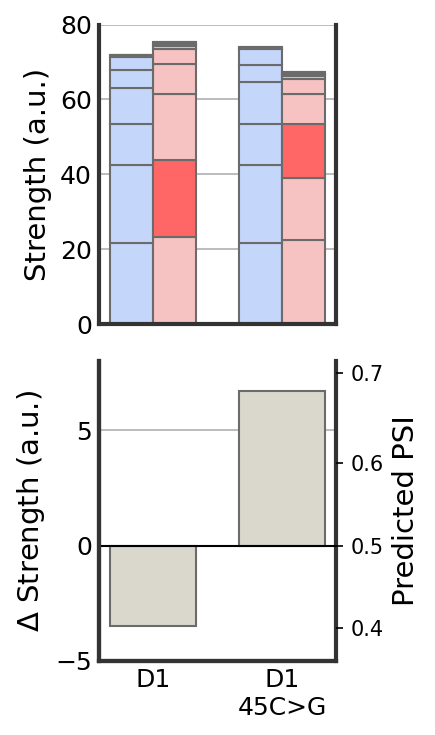

In [55]:
axarr, fig = draw_force_plot(porg_incl_act, porg_skip_act,
                             annotations,
                             seq_filters_grouping, struct_filters_grouping,
                             num_seq_filters, link_midpoint, highlight_forces,
                             incl_color, skip_color, light_incl_color, light_skip_color, 
                             delta_force_y_range=(-5, 8), force_y_range=(0, 80),
                             ys=[0.4, 0.5, 0.6, 0.7], delta_bar_width=2.0, width_ratios=[2, 2, 1], vertical=True, 
                             figsize=(3, 5), sharex=True
                            )

fig.savefig('./figs/D1.svg',
            transparent=True, pad_inches=0.1,
    bbox_inches='tight')
fig.savefig('./figs/D1.pdf',
            transparent=True, pad_inches=0.1,
    bbox_inches='tight')
fig.savefig('./figs/D1.png',
            transparent=True, pad_inches=0.1,
    bbox_inches='tight')

### validation: c4, c3, c2, c10, c8

In [56]:
structure_exons = ['GCGGCACCTACTACAATGTCCCCCGCTGCATACACTCGGAGCCAATAGGGCGCCTATAGAGTGTAGTCCT',
                   'TCGCACCGCAGGTTCGGTTTTTTGGTATAATACGCGGCACTCCAAAATTACTCTGGGGCACCCTCACCAG',
                   'GCCCGAAAGCTCCCTACTGCAGTTTACGACCCTTAAGGCTTGGGTGCTCTTACGCGCTGATCGATATAAG',
                   'CCCTACCCGCCCTCGTCCCCAGGACACCCTTTCCGCCGCAAGTTATCCGCCAAGTACACAACTTAATGGT',
                   'GGTGTCCCCCACTATCGACCTCATCAGTAATCAATCCGAGCGACCGCCTCATCCCAAAGGCACACGTCCA'
                   ]
annotations = [f'V{i}' for i in [1, 2, 3, 4, 5]]

structure_sequences = [
    figutils.add_flanking(e, 10) for e in structure_exons
]
structure_data = figutils.create_input_data(structure_sequences)
structure_incl_act, structure_skip_act = structure_out_model.predict(
    structure_data)

highlight_forces = []

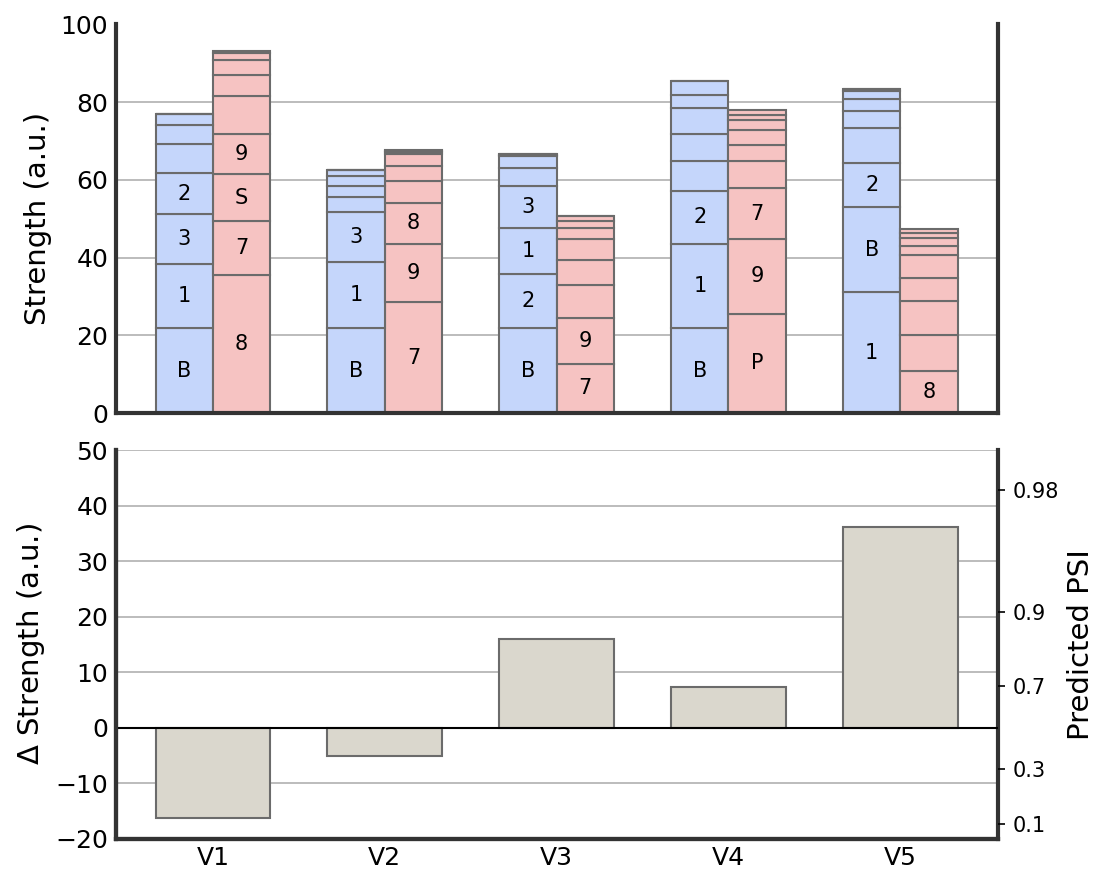

In [57]:
axarr, fig = draw_force_plot(structure_incl_act, structure_skip_act,
                             annotations,
                             seq_filters_grouping, struct_filters_grouping,
                             num_seq_filters, link_midpoint, highlight_forces,
                             incl_color, skip_color, light_incl_color, light_skip_color,
                             delta_force_y_range=(-20, 50), force_y_range=(0, 100), figsize=(6/4*5, 6),
                             draw_numbers=True, numbers_min_bar_height=10,
                             ys=[0.1, 0.3, 0.7, 0.9, 0.975], width_ratios=[2, 2], delta_bar_width=2,
                             vertical=True, sharex=True
                            )

fig.savefig('./figs/V1-5.svg',
            transparent=True, pad_inches=0.1,
    bbox_inches='tight')
fig.savefig('./figs/V1-5.pdf',
            transparent=True, pad_inches=0.1,
    bbox_inches='tight')
fig.savefig('./figs/V1-5.png',
            transparent=True, pad_inches=0.1,
    bbox_inches='tight')

### porgs 4, 9, 10 (supplement)

In [58]:
porg_exon_sets = [
    ["CCGTGGTCCAACACTCCGATTATATCCCTACTCCCGTTATGTGTTAAGACTCAAGTTCCTCTCTATCCAC",
     "CCGTGGTCCAACACTCCGATTATATCGCTACTCCCGTTATGTGTTAAGACTCAAGTTCCTCTCTATCCAC", ],
    ["GACTATGAGCCCCAACGAACAAGCTCCTATCTGGGAACTCTTTTCTGCAGACTTTAACCCTACCCCCAGA",
     "GACTATGAGCCCCAACGAACAAGCTCCTATCTGGGAACTCTTTTCTGCAGACTTTAAGCCTACCCCCAGA", ],
    ["ACGCCCCCCACCCTCACCGACATATAATTGCCCTTCCCGCAGTATGCTTCAGTTAACGATACTACAGTTC",
     "ACGCCCCCCACCCTCACCGACATATAATTGGCCTTCCCGCAGTATGCTTCAGTTAACGATACTACAGTTC", ]]

In [59]:
filename_prefixes = ['D2', 'D3', 'D4']
annotation_sets = [[add_subscript(fp, subscript) for subscript in get_mutation_names(porg_exons, rna=True)]
                   for fp, porg_exons in zip(filename_prefixes, porg_exon_sets)]

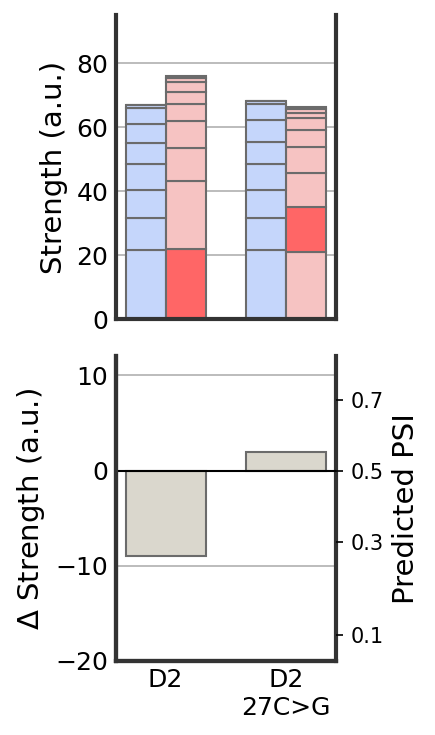

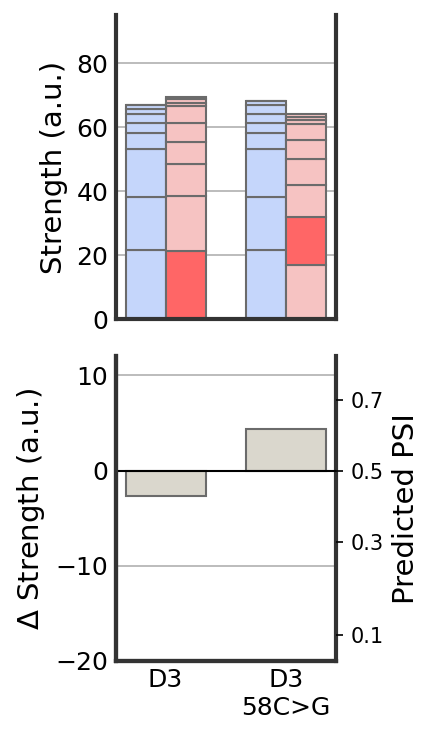

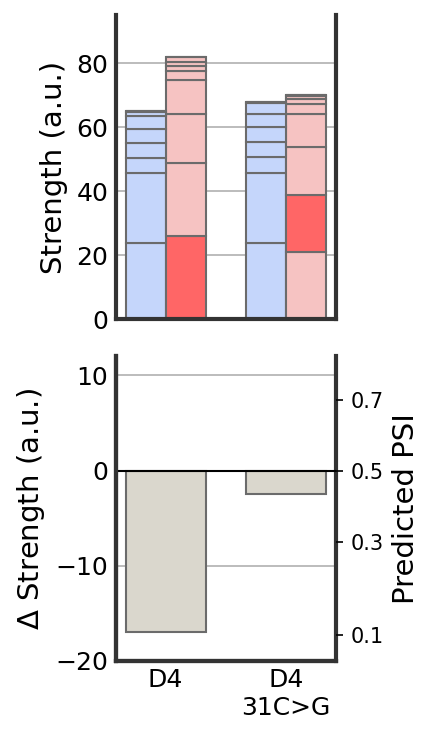

In [60]:
for porg_exons, annotations, filename_prefix in zip(porg_exon_sets, annotation_sets, filename_prefixes):
    porg_sequences = [
        figutils.add_flanking(e, 10) for e in porg_exons
    ]
    porg_data = figutils.create_input_data(porg_sequences)
    porg_incl_act, porg_skip_act = structure_out_model.predict(porg_data)

    highlight_forces = ['skip_struct_1']

    axarr, fig = draw_force_plot(porg_incl_act, porg_skip_act,
                                 annotations,
                                 seq_filters_grouping, struct_filters_grouping,
                                 num_seq_filters, link_midpoint, highlight_forces,
                                 incl_color, skip_color, light_incl_color, light_skip_color, 
                                 delta_force_y_range=(-20, 12), force_y_range=(0, 95),
                                 ys=[0.1, 0.3, 0.5, 0.7], delta_bar_width=2.0, width_ratios=[2, 2],
                                 vertical=True, figsize=(3, 5), sharex=True
                                )

    fig.savefig(f'./figs/{filename_prefix}.svg',
                transparent=True, pad_inches=0.1,
        bbox_inches='tight')
    fig.savefig(f'./figs/{filename_prefix}.pdf',
                transparent=True, pad_inches=0.1,
        bbox_inches='tight')
    fig.savefig(f'./figs/{filename_prefix}.png',
                transparent=True, pad_inches=0.1,
        bbox_inches='tight')
    plt.show()

### structure sequences 2c4, 2c5 (supplement)

In [61]:
structure_exon_sets = [
    [
        'TCGCTCTCTAAAAAAGTCACCTACTTAACACGACGTGCCTCCGTGGCACGAAAATAAACCACTAAGAAAA',
        'TCGCTCTCTAAAAAAGTCACCTACTTAACACGACGGGCCTCCGTGGCACGAAAATAAACCACTAAGAAAA',
        'TCGCTCTCTAAAAAAGTCACCTACTTAACACGACGTGCCTCCGTGGCCCGAAAATAAACCACTAAGAAAA',
        'TCGCTCTCTAAAAAAGTCACCTACTTAACACGACGGGCCTCCGTGGCCCGAAAATAAACCACTAAGAAAA',
    ], [
        'TCTGCCCCTACACACAGGCACCTCGGCGATCGCCCGGGACACATCCGGGCCCTTGTTTCTATTCCGCCTC',
        'TCTGCCCCTACACACAGGCACCTCGGCGATCGCCAGGGACACATCCGGGCCCTTGTTTCTATTCCGCCTC',
        'TCTGCCCCTACACACAGGCACCTCGGCGATCGCCCGGGACACATCCTGGCCCTTGTTTCTATTCCGCCTC',
        'TCTGCCCCTACACACAGGCACCTCGGCGATCGCCAGGGACACATCCTGGCCCTTGTTTCTATTCCGCCTC',
    ]
]

filename_prefixes = ['S2', 'S3']

annotation_sets = [[add_subscript(fp, subscript) for subscript in get_mutation_names(structure_exons, rna=True)]
                   for fp, structure_exons in zip(filename_prefixes, structure_exon_sets)]

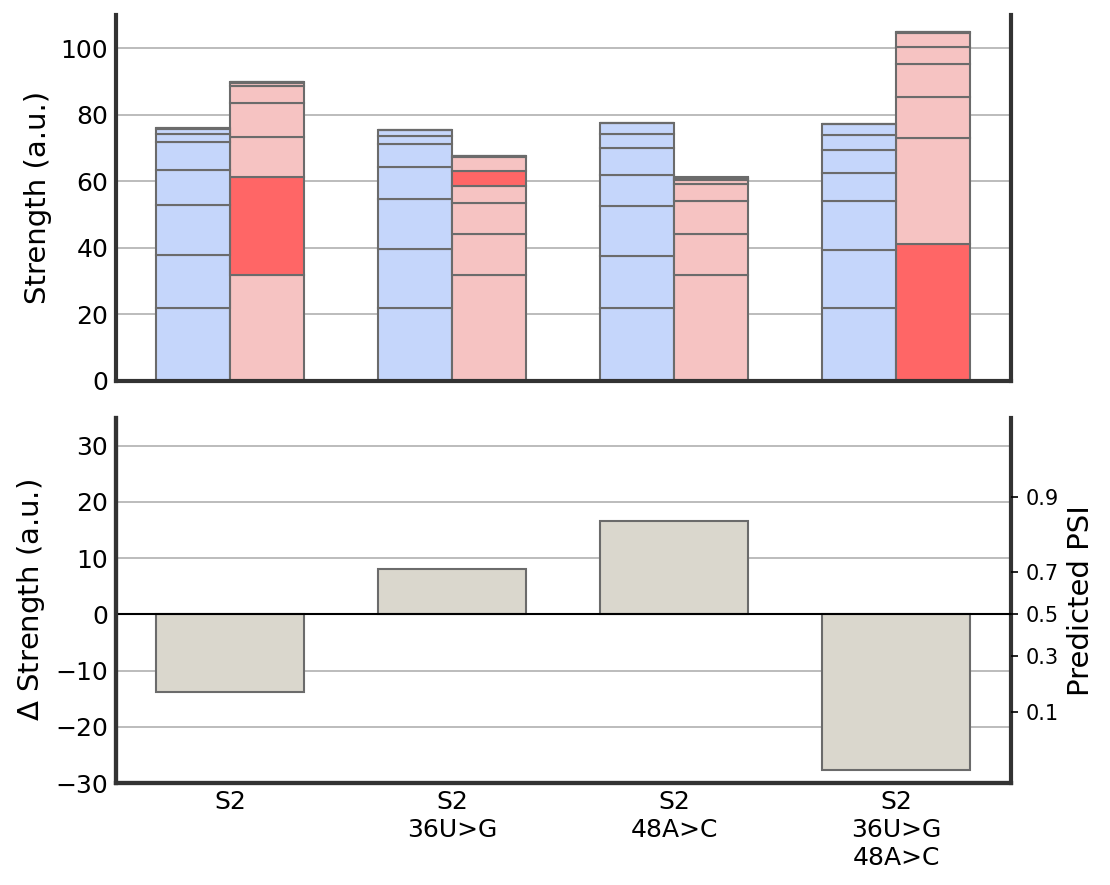

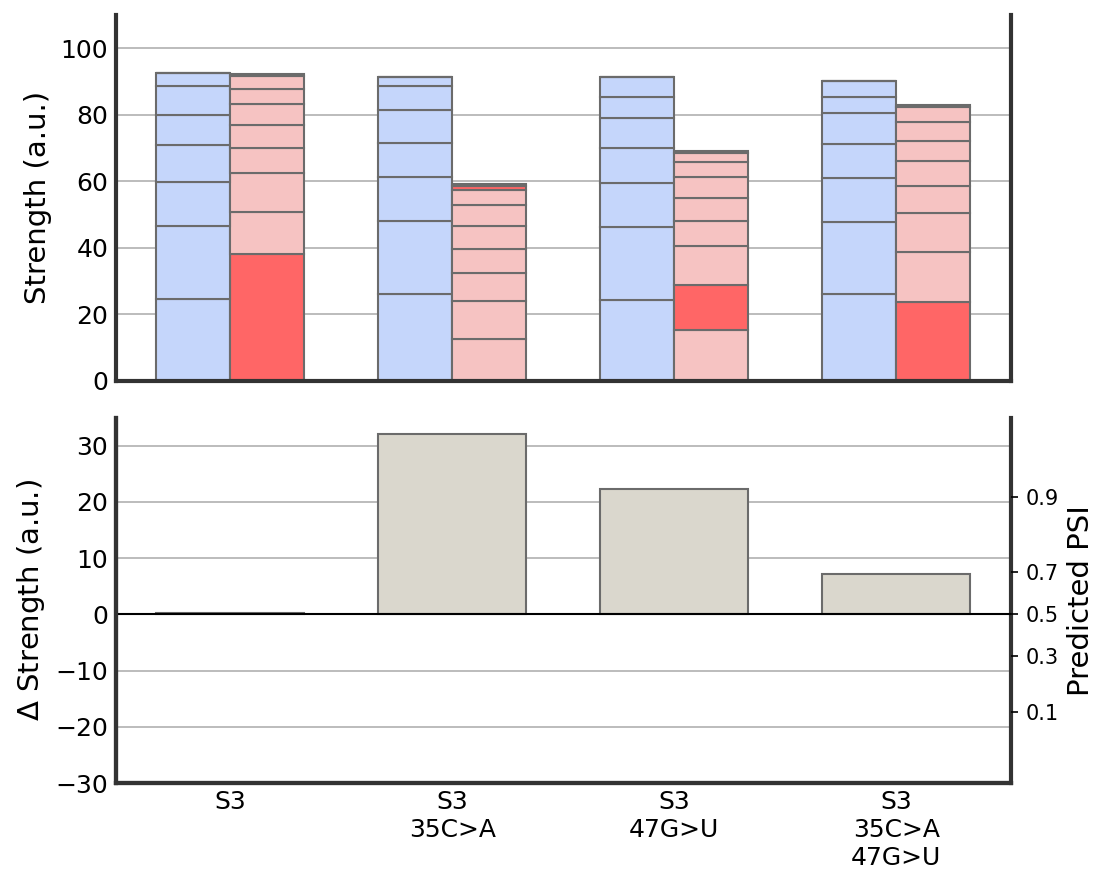

In [62]:
for structure_exons, annotations, filename_prefix in zip(structure_exon_sets, annotation_sets, filename_prefixes):
    structure_sequences = [
        figutils.add_flanking(e, 10) for e in structure_exons
    ]
    structure_data = figutils.create_input_data(structure_sequences)
    structure_incl_act, structure_skip_act = structure_out_model.predict(
        structure_data)

    highlight_forces = ['skip_struct_0_2_3']

    axarr, fig = draw_force_plot(structure_incl_act, structure_skip_act,
                                 annotations,
                                 seq_filters_grouping, struct_filters_grouping,
                                 num_seq_filters, link_midpoint, highlight_forces,
                                 incl_color, skip_color, light_incl_color,
                                 light_skip_color, figsize=(6/4*5, 6),
                                 delta_force_y_range=(-30, 35), force_y_range=(0, 110),
                                 ys=[0.1, 0.3, 0.5, 0.7, 0.9], delta_bar_width=2.0,
                                 vertical=True, sharex=True
                                )
    
    fig.savefig(f'./figs/{filename_prefix}.svg',
                transparent=True, pad_inches=0.1,
        bbox_inches='tight')
    fig.savefig(f'./figs/{filename_prefix}.pdf',
                transparent=True, pad_inches=0.1,
        bbox_inches='tight')
    fig.savefig(f'./figs/{filename_prefix}.png',
                transparent=True, pad_inches=0.1,
        bbox_inches='tight')
    plt.show()

## Model explanation force plot

In [63]:
exons = ['GCGGCACCTACTACAATGTCCCCCGCTGCATACACTCGGAGCCAATAGGGCGCCTATAGAGTGTAGTCCT']
annotations = ['']

sequences = [
    figutils.add_flanking(e, 10) for e in exons
]
data = figutils.create_input_data(sequences)
incl_act, skip_act = structure_out_model.predict(data)

highlight_forces = []  # ['skip_struct_0_2_3']

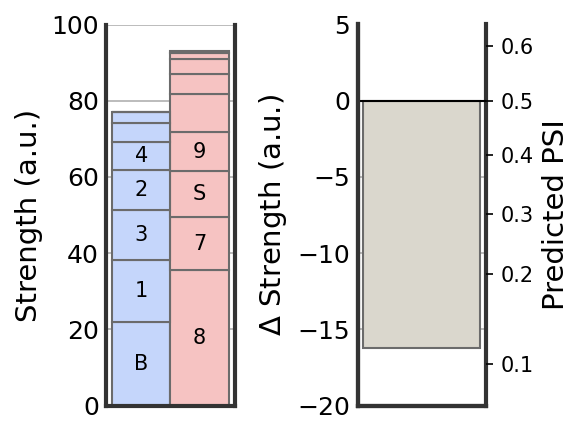

In [64]:
axarr, fig = draw_force_plot(incl_act, skip_act,
                             annotations,
                             seq_filters_grouping, struct_filters_grouping,
                             num_seq_filters, link_midpoint, highlight_forces,
                             incl_color, skip_color, light_incl_color, light_skip_color,
                             delta_force_y_range=(-20, 5), force_y_range=(0, 100), figsize=(4, 3),
                             draw_numbers=True, numbers_min_bar_height=6, delta_bar_width=2,
                             width_ratios=[2, 2]
                            )

# axarr[-1].axis('off')
fig.savefig('./figs/exon.svg',
            transparent=True, pad_inches=0.1,
    bbox_inches='tight')